In [35]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

from seiz_eeg.dataset import EEGDataset

# The data

We model *segments* of brain activity, which correspond to windows of a longer *session* of EEG recording.

These segments, and their labels, are described in the `segments.parquet` files, which can be directly loaded with `pandas`.

In [36]:
# You might need to change this according to where you store the data folder
# Inside your data folder, you should have the following structure:
# data
# ├── train
# │   ├── signals/
# │   ├── segments.parquet
# │-- test
#     ├── signals/
#     ├── segments.parquet

data_path = "data/data"

DATA_ROOT = Path(data_path)




In [65]:
bp_filter = signal.butter(4, (0.5, 30), btype="bandpass", output="sos", fs=250)


def time_filtering(x: np.ndarray) -> np.ndarray:
    """Filter signal in the time domain"""
    return signal.sosfiltfilt(bp_filter, x, axis=0).copy()


def fft_filtering(x: np.ndarray) -> np.ndarray:
    """Compute FFT and only keep"""
    x = np.abs(np.fft.fft(x, axis=0))
    x = np.log(np.where(x > 1e-8, x, 1e-8))

    win_len = x.shape[0]
    # Only frequencies b/w 0.5 and 30Hz
    return x[int(0.5 * win_len // 250) : 30 * win_len // 250]

def normalize_eeg(x: np.ndarray) -> np.ndarray:
    """
    Normalize EEG signal between -1 and 1 per channel.

    Parameters:
    - x: EEG signal, shape (time, channels)

    Returns:
    - Normalized signal
    """
    min_vals = x.min(axis=0)
    max_vals = x.max(axis=0)
    return 2 * (x - min_vals) / (max_vals - min_vals + 1e-8) - 1 

from scipy.signal import hilbert
import numpy as np
from scipy.signal import resample

def downsample(x: np.ndarray) -> np.ndarray:
    
    
    # Resample the analytic signal to 300 samples
    downsampled_signal = resample(x, 300, axis=0)
    
    return downsampled_signal


In [66]:

data_root = Path(data_path)
clips_tr = pd.read_parquet(data_root / "train/segments.parquet")
ids = clips_tr["signals_path"].astype(str).tolist()
ids = list(map(lambda x: x[x.find("_") + 1 : x.find("_") + 5], ids))
clips_tr["subject_id"] = ids
clips_tr.head()
# calulate ratio bewteen label 0 and label 1 per unique subject
ratio = clips_tr.groupby("subject_id")["label"].value_counts(normalize=True).unstack()
print(ratio)
# print subject ids 
unique_subjects = clips_tr["subject_id"].unique()
print(unique_subjects)
# print number of clips per subject
print(clips_tr["subject_id"].value_counts())
# print the percentage of clips per subject
print(clips_tr["subject_id"].value_counts(normalize=True))
        

label              0         1
subject_id                    
s001        0.757630  0.242370
s002        0.831869  0.168131
s003        0.840773  0.159227
s004        0.810518  0.189482
s005        0.919028  0.080972
s006        0.837209  0.162791
s007        0.973913  0.026087
s008        0.854167  0.145833
s009        0.758929  0.241071
s010        0.811765  0.188235
s011        0.960784  0.039216
s015             NaN  1.000000
['s001' 's002' 's003' 's005' 's004' 's009' 's011' 's015' 's010' 's008'
 's006' 's007']
subject_id
s001    5046
s002    2504
s003    2173
s004    1198
s005     741
s006     430
s009     224
s008     192
s010     170
s011     153
s007     115
s015      47
Name: count, dtype: int64
subject_id
s001    0.388363
s002    0.192719
s003    0.167244
s004    0.092203
s005    0.057031
s006    0.033095
s009    0.017240
s008    0.014777
s010    0.013084
s011    0.011776
s007    0.008851
s015    0.003617
Name: proportion, dtype: float64


In [69]:
# You can change the signal_transform, or remove it completely
dataset_tr = EEGDataset(
    clips_tr,
    signals_root=DATA_ROOT / "train",
    signal_transform=downsample,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)


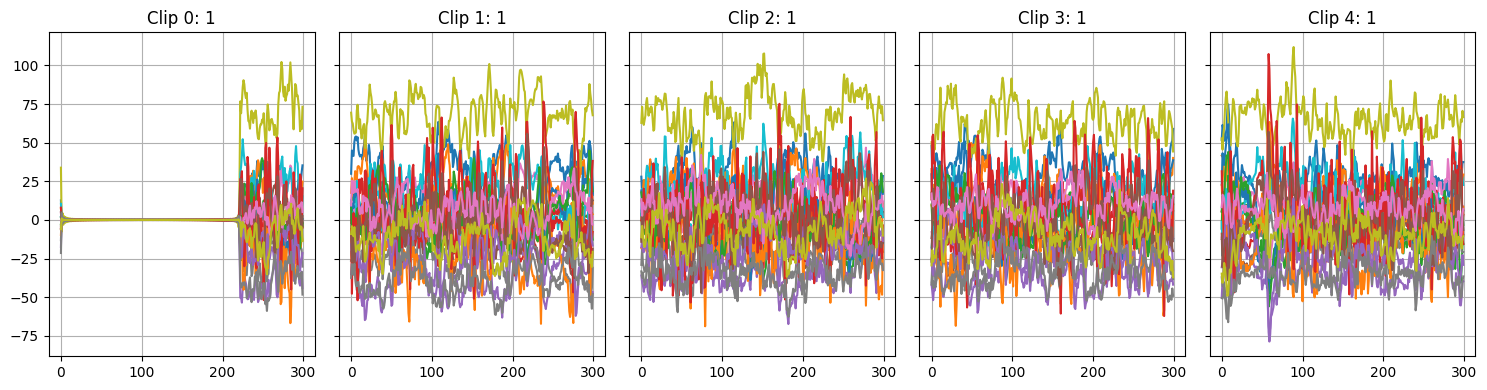

In [70]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i, (x, y) in enumerate(dataset_tr):
    if i > 4:
        break
    axes[i].plot(x)
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: {y}"))

fig.tight_layout()
plt.show()


In [71]:
# print the shape of the dataset
print(f"Dataset shape: {dataset_tr.__len__()}")
# print the shape of the first 10 clips
for i in range(10):
    x, y = dataset_tr[i]
    print(f"Clip {i} shape: {x.shape}, label: {y}")

Dataset shape: 12993
Clip 0 shape: (300, 19), label: 1
Clip 1 shape: (300, 19), label: 1
Clip 2 shape: (300, 19), label: 1
Clip 3 shape: (300, 19), label: 1
Clip 4 shape: (300, 19), label: 1
Clip 5 shape: (300, 19), label: 1
Clip 6 shape: (300, 19), label: 1
Clip 7 shape: (300, 19), label: 1
Clip 8 shape: (300, 19), label: 1
Clip 9 shape: (300, 19), label: 1


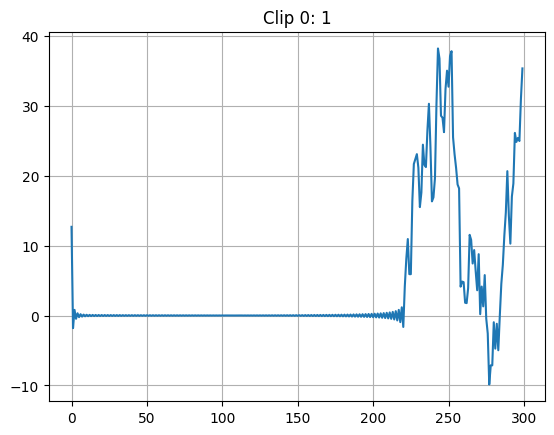

In [72]:
clip, y = dataset_tr[0]
#plot first channel
plt.plot(clip[:, 0])
plt.title(f"Clip 0: {y}")
plt.grid()
plt.show()


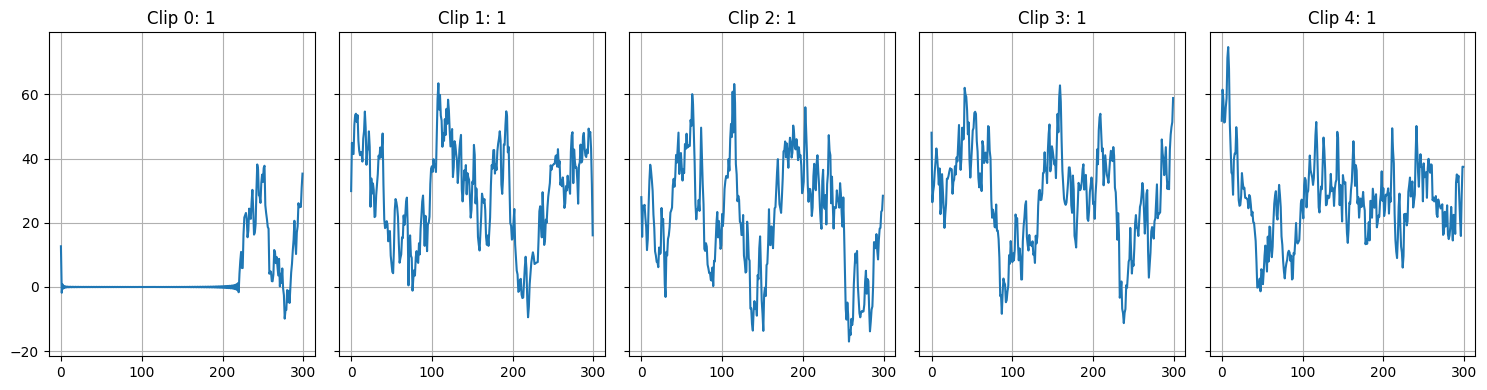

In [73]:
x = []
labels = []
for i in range(len(dataset_tr)):
    clip, y = dataset_tr[i]
    x.append(clip[:, 0])
    labels.append(y)
x = np.array(x)
labels = np.array(labels)
# plot first 5 clips
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i in range(5):
    axes[i].plot(x[i])
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: {labels[i]}"))
fig.tight_layout()
plt.show()

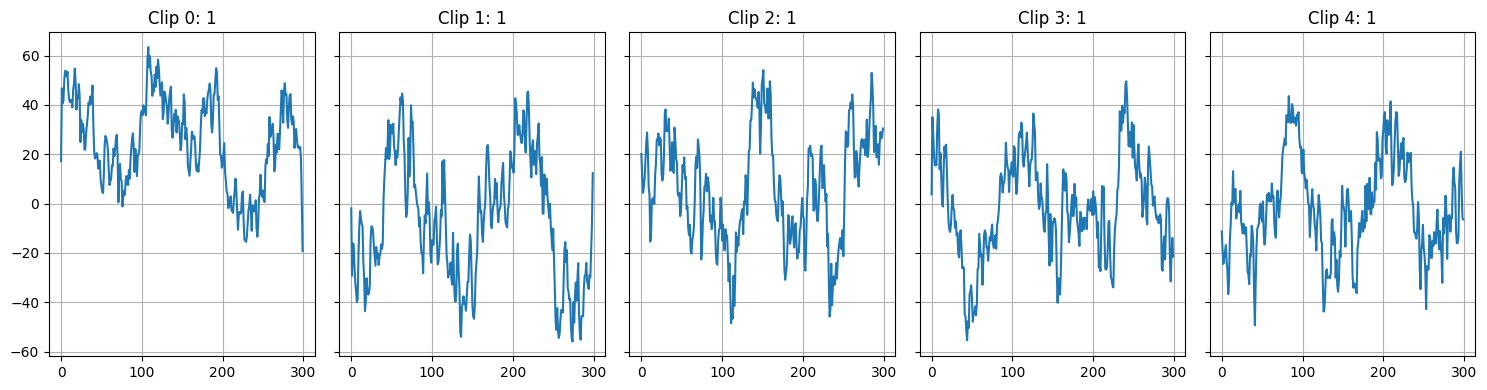

In [74]:
# compute diff of t and t + 1 of data
signals = x
x = np.diff(x, axis=0)
# plot first 5 clips
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i in range(5):
    axes[i].plot(x[i])
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: {labels[i]}"))
fig.tight_layout()
plt.show()

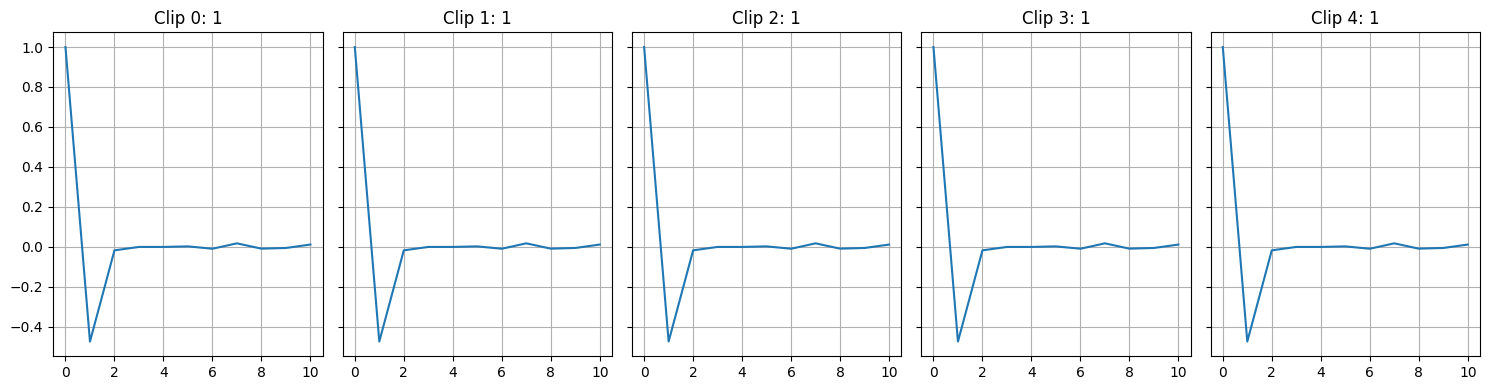

In [75]:
# compute acf of each data and compute mean
from statsmodels.tsa.stattools import acf
def compute_acf(x: np.ndarray, lags: int = 100) -> np.ndarray:
    """
    Compute the autocorrelation function (ACF) of a signal.

    Parameters:
    - x: Input signal, shape (time, channels)
    - lags: Number of lags to compute

    Returns:
    - ACF values for each channel
    """
    acf_values = []
    for i in range(x.shape[1]):
        acf_values.append(acf(x[:, i], nlags=lags))
    mean_acf = np.mean(acf_values, axis=0)
    return mean_acf
lags = 10
mean_acf = compute_acf(x, lags=lags)
# plot acf
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i in range(5):
    axes[i].plot(mean_acf)
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: {labels[i]}"))
fig.tight_layout()
plt.show()


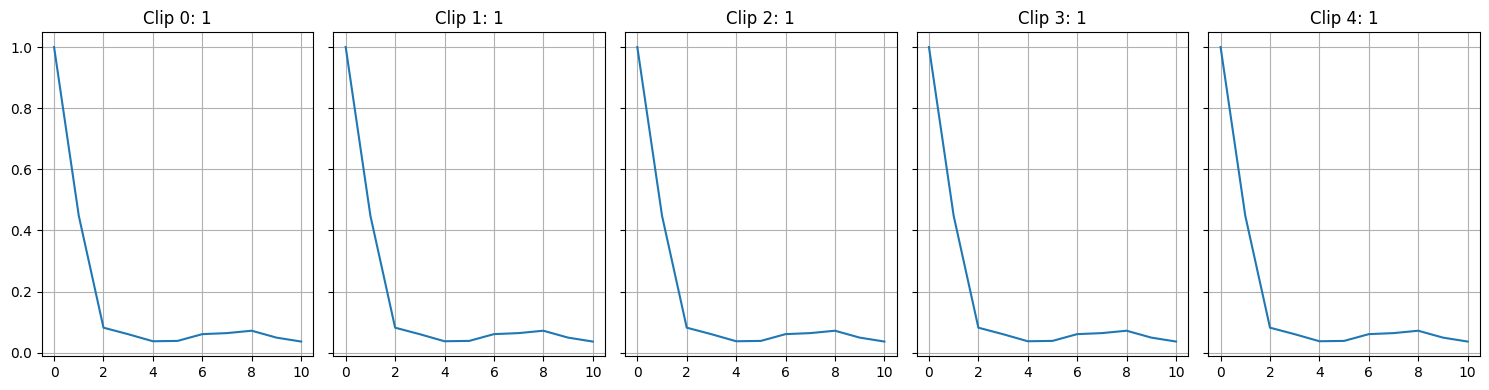

In [76]:
# compute acf volatility
x_squared = x ** 2
mean_acf_squared = compute_acf(x_squared, lags=lags)
# plot acf
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i in range(5):
    axes[i].plot(mean_acf_squared)
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: {labels[i]}"))
fig.tight_layout()
plt.show()

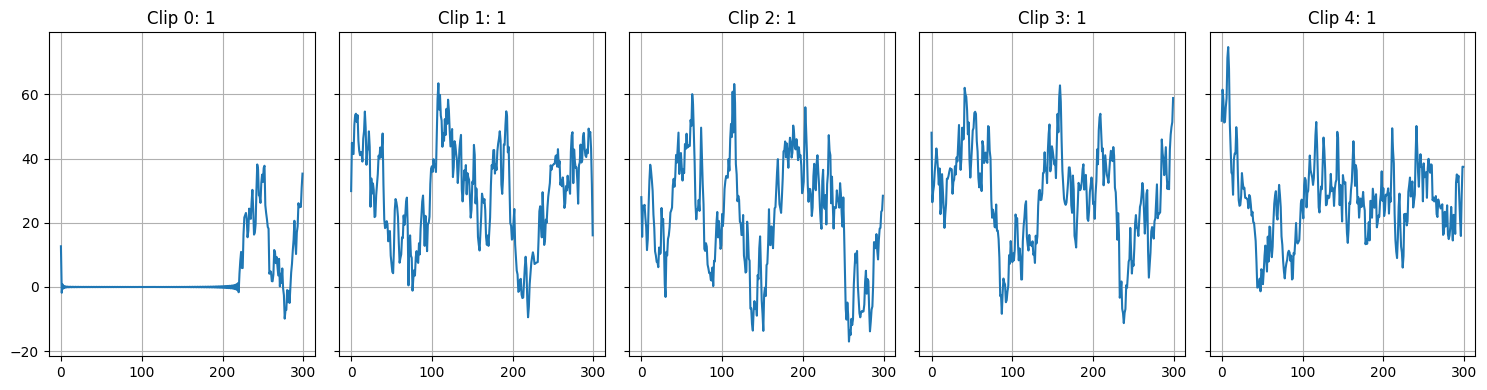

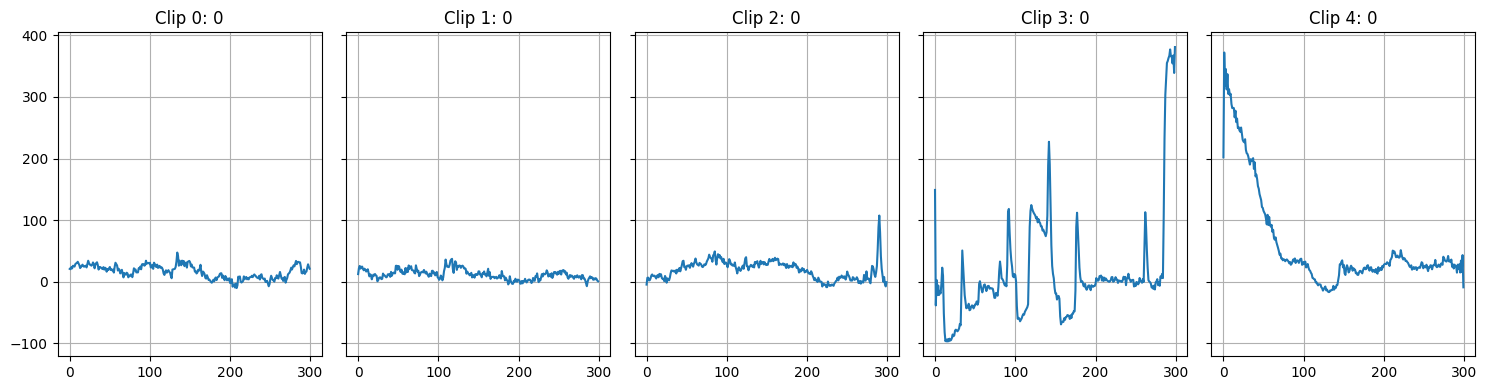

In [77]:
#plot signal label 1 and label 0
# get all signals with label 1
x_label_1 = signals[labels == 1]
# get all signals with label 0
x_label_0 = signals[labels == 0]
# plot first 5 signals with label 1
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i in range(5):
    axes[i].plot(x_label_1[i])
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: 1"))
fig.tight_layout()
plt.show()
# plot first 5 signals with label 0
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i in range(5):
    axes[i].plot(x_label_0[i])
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: 0"))
fig.tight_layout()
plt.show()

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
clips_df = pd.read_parquet(DATA_ROOT / "train/segments.parquet")

# Get actual path values
ids = clips_df["signals_path"].astype(str).tolist()

# Keep only a specific part of the string
ids = list(map(lambda x: x[x.find("_") + 1:x.find("_") + 5], ids))

# Add the new column to the dataframe
clips_df["subject_id"] = ids

# Show a few values
print(clips_df[["signals_path", "subject_id"]].head())

# Get unique subjects
unique_subjects = clips_df["subject_id"].unique()
print(f"Unique subjects: {unique_subjects}")

# Step 1: Get the unique subject IDs
unique_subjects = clips_df["subject_id"].unique()

# Step 2: Split subjects into train and validation groups
train_subjects, val_subjects = train_test_split(
    unique_subjects,
    test_size=0.2,
    random_state=42
)

# Step 3: Filter clips_df to create train and validation sets
clips_train = clips_df[clips_df["subject_id"].isin(train_subjects)].reset_index(drop=True)
clips_val = clips_df[clips_df["subject_id"].isin(val_subjects)].reset_index(drop=True)

# Optional: Confirm no leakage
assert set(clips_train["subject_id"]) & set(clips_val["subject_id"]) == set(), "Leakage detected!"

# ✅ Done!
print(f"Train subjects: {len(train_subjects)}, Validation subjects: {len(val_subjects)}")
print(f"Train clips: {len(clips_train)}, Validation clips: {len(clips_val)}")

data_tr = EEGDataset(
    clips_train,
    signals_root=DATA_ROOT / "train",
    signal_transform=fft_filtering,
    prefetch=True,
)

data_val = EEGDataset(
    clips_val,
    signals_root=DATA_ROOT / "train",
    signal_transform=fft_filtering,
    prefetch=True,
)




                                            signals_path subject_id
id                                                                 
pqejgcff_s001_t000_0  signals/pqejgcff_s001_t000.parquet       s001
pqejgcff_s001_t000_1  signals/pqejgcff_s001_t000.parquet       s001
pqejgcff_s001_t000_2  signals/pqejgcff_s001_t000.parquet       s001
pqejgcff_s001_t000_3  signals/pqejgcff_s001_t000.parquet       s001
pqejgcff_s001_t000_4  signals/pqejgcff_s001_t000.parquet       s001
Unique subjects: ['s001' 's002' 's003' 's005' 's004' 's009' 's011' 's015' 's010' 's008'
 's006' 's007']
Train subjects: 9, Validation subjects: 3
Train clips: 7325, Validation clips: 5668


In [70]:
dataset_train = EEGDataset(
    clips_train,
    signals_root=DATA_ROOT / "train",
    signal_transform=fft_filtering,
    prefetch=True,
)

# count number of labels == 1 and == 0
labels = clips_train["label"].values
print(f"Number of labels == 1: {np.sum(labels == 1)}")
print(f"Number of labels == 0: {np.sum(labels == 0)}")

dataset_val = EEGDataset(
    clips_val,
    signals_root=DATA_ROOT / "train",
    signal_transform=fft_filtering,
    prefetch=True,
)
# count number of labels == 1 and == 0
labels = clips_val["label"].values
print(f"Number of labels == 1: {np.sum(labels == 1)}")
print(f"Number of labels == 0: {np.sum(labels == 0)}")

Number of labels == 1: 1196
Number of labels == 0: 6129
Number of labels == 1: 1321
Number of labels == 0: 4347


## Loading the signals

For convenience, the `EEGDataset class` provides functionality for loading each segment and its label as `numpy` arrays.

You can provide an optional `signal_transform` function to preprocess the signals. In the example below, we have two bandpass filtering functions, which extract frequencies between 0.5Hz and 30Hz which are used in seizure analysis literature:

The `EEGDataset` class also allows to load all data in memory, instead of reading it from disk at every iteration. If your compute allows it, you can use `prefetch=True`.

In [5]:
# evaluate the model
from sklearn.metrics import roc_auc_score, f1_score
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from models.lstm_gat import EEGGraphModel
import yaml

# Load the model


def load_config(path):
    with open(path, 'r') as f:
        return yaml.safe_load(f)

config_path = "configs/best_config_0_78.yaml"
config = load_config(config_path)
# Load the model
model = EEGGraphModel(
    input_dim=config["model"]["input_dim"],
    lstm_hidden_dim=config["model"]["lstm_hidden_dim"],
    gat_hidden_dim=config["model"]["gat_hidden_dim"],
    output_dim=config["model"]["output_dim"],
    gat_heads=config["model"]["gat_heads"],
    lstm_layers=config["model"]["lstm_layers"],
    fully_connected=config["model"]["fully_connected"],
)

# Load the model weights
model_path = "results/best_model_0_78.pt"
model.load_state_dict(torch.load(model_path))
# Create test dataset
dataset_te = EEGDataset(
    clips_te,  # Your test clips variable
    signals_root=DATA_ROOT
    / "test",  # Update this path if your test signals are stored elsewhere
    signal_transform=fft_filtering,  # You can change or remove the signal_transform as needed
    prefetch=True,  # Set to False if prefetching causes memory issues on your compute environment
    return_id=True,  # Return the id of each sample instead of the label
)

# Create DataLoader for the test dataset
loader_te = DataLoader(dataset_te, batch_size=config["training"]["batch_size"], shuffle=False)

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move the model to the device
model.to(device)
# Generate the submission file for Kaggle

# Set the model to evaluation mode
model.eval()

# Lists to store sample IDs and predictions
all_predictions = []
all_ids = []

# Disable gradient computation for inference
with torch.no_grad():
    for batch in loader_te:
        # Assume each batch returns a tuple (x_batch, sample_id)
        # If your dataset does not provide IDs, you can generate them based on the batch index.
        x_batch, x_ids = batch
        # Move the input data to the device (GPU or CPU)
        x_batch = x_batch.float().to(device)

        # Perform the forward pass to get the model's output logits
        logits = model(x_batch)

        # Convert logits to predictions.
        # For binary classification, threshold logits at 0 (adjust this if you use softmax or multi-class).
        probs = torch.sigmoid(torch.tensor(logits)).numpy()
        predictions = (probs >= 0.5).astype(int) 

        # Append predictions and corresponding IDs to the lists
        all_predictions.extend(predictions.flatten().tolist())
        all_ids.extend(list(x_ids))

# Create a DataFrame for Kaggle submission with the required format: "id,label"
#remove underscore that are not followed by an underscore
all_ids = [str(i).replace("__", "$$") for i in all_ids]
all_ids = [i.replace("_", "") for i in all_ids]
all_ids = [i.replace("$$", "_") for i in all_ids]
print(all_ids)
submission_df = pd.DataFrame({"id": all_ids, "label": all_predictions})

# Save the DataFrame to a CSV file without an index
submission_df.to_csv("submission_seed1.csv", index=False)
print("Kaggle submission file generated: submission.csv")

/var/folders/dd/nv1lky5s1851076c3xc874p80000gn/T/ipykernel_72836/1243078929.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  probs = torch.sigmoid(torch.tensor(logits)).numpy()


['pqejgcvm_s001_t000_0', 'pqejgcvm_s001_t000_1', 'pqejgcvm_s001_t000_2', 'pqejgcvm_s001_t000_3', 'pqejgcvm_s001_t000_4', 'pqejgcvm_s001_t000_5', 'pqejgcvm_s001_t000_6', 'pqejgcvm_s001_t000_7', 'pqejgcvm_s001_t000_8', 'pqejgcvm_s001_t000_9', 'pqejgcvm_s001_t000_10', 'pqejgcvm_s001_t000_11', 'pqejgcvm_s001_t000_12', 'pqejgcvm_s001_t000_13', 'pqejgcvm_s001_t000_14', 'pqejgcvm_s001_t000_15', 'pqejgcvm_s001_t000_16', 'pqejgcvm_s001_t000_17', 'pqejgcvm_s001_t000_18', 'pqejgcvm_s001_t000_19', 'pqejgcvm_s001_t000_20', 'pqejgcvm_s001_t000_21', 'pqejgcvm_s001_t000_22', 'pqejgcvm_s001_t000_23', 'pqejgcvm_s001_t000_24', 'pqejgcvm_s001_t001_0', 'pqejgcvm_s001_t001_1', 'pqejgcvm_s001_t001_2', 'pqejgcvm_s001_t001_3', 'pqejgcvm_s001_t001_4', 'pqejgcvm_s001_t001_5', 'pqejgcvm_s001_t001_6', 'pqejgcvm_s001_t001_7', 'pqejgcvm_s001_t001_8', 'pqejgcvm_s001_t001_9', 'pqejgcvm_s001_t001_10', 'pqejgcvm_s001_t001_11', 'pqejgcvm_s001_t001_12', 'pqejgcvm_s001_t001_13', 'pqejgcvm_s001_t001_14', 'pqejgcvm_s001_t001

In [6]:
# eval the model just to be sure 
from sklearn.model_selection import train_test_split
#summary import
from sklearn.metrics import classification_report, confusion_matrix


clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")
dataset_tr = EEGDataset(
    clips_tr,
    signals_root=DATA_ROOT / "train",
    signal_transform=fft_filtering,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)
train_clips, val_clips = train_test_split(
    clips_tr, test_size=0.2, random_state=62, stratify=clips_tr["label"]
)

dataset_val = EEGDataset(
    val_clips,
    signals_root=DATA_ROOT / "train",
    signal_transform=fft_filtering,
    prefetch=True,
)

val_dataloader = DataLoader(
    dataset_val,
    batch_size=config["training"]["batch_size"],
    shuffle=False,
)

def evaluate_model(model, dataloader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            x_batch, y_batch = batch
            x_batch = x_batch.float().to(device)
            y_batch = y_batch.float().to(device)

            logits = model(x_batch)
            probs = torch.sigmoid(torch.tensor(logits)).numpy()
            predictions = (probs >= 0.5).astype(int)

            all_predictions.extend(predictions.flatten().tolist())
            all_labels.extend(y_batch.cpu().numpy().flatten().tolist())

    return np.array(all_labels), np.array(all_predictions)

# Evaluate the model on the validation set
y_true, y_pred = evaluate_model(model, val_dataloader)
# Calculate classification metrics
print("Classification Report:")
print(classification_report(y_true, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

  0%|                                                    | 0/82 [00:00<?, ?it/s]/var/folders/dd/nv1lky5s1851076c3xc874p80000gn/T/ipykernel_72836/320342311.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  probs = torch.sigmoid(torch.tensor(logits)).numpy()
100%|███████████████████████████████████████████| 82/82 [02:38<00:00,  1.93s/it]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93      2096
         1.0       0.73      0.63      0.68       503

    accuracy                           0.88      2599
   macro avg       0.82      0.79      0.80      2599
weighted avg       0.88      0.88      0.88      2599

Confusion Matrix:
[[1982  114]
 [ 188  315]]
